In [1]:
from bokeh.io import output_notebook # to plot "show()" on the notebook, without opening a browser
output_notebook()

Loading BokehJS ...

In [2]:
from bloqade import var, save, load, piecewise_linear, rydberg_h
from bloqade.atom_arrangement import Chain, Square, Honeycomb, ListOfLocations
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
s = 6
y = 3.464
# atom_pos = Honeycomb(2, lattice_spacing=2*s)
atom_pos = ListOfLocations([(s, 3*y), (2*s, 4*y), (3*s, 3*y), (4*s, 4*y), (5*s, 3*y),
                             (5*s, y), (4*s, 0), (3*s, y), (2*s, 0), (s, y)])

atom_pos.show()

In [4]:
# State Preparation
delta_durations_state_prep = [0.3, 1.6, 0.3]
delta_state_prep = [-18.8, -18.8, 16.3, 16.3] # longer than durations by 1

omega_durations_state_prep = [0.3, 1.6, 0.3]
omega_state_prep = [0.0, 15.7, 15.7, 0.0] # longer than durations by 1

# Scaring
delta_durations_scaring = [0.2, 6.6]
delta_scaring = [16.3, 0.0, 0.0] # longer than durations by 1

omega_durations_scaring = [0.2, 1.4, 5.2]
omega_scaring = [0, 15.7, 15.7, 0] # longer than durations by 1

In [5]:
run_time = var("run_time")

quantum_scar_program = (
    atom_pos
    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(
        delta_durations_state_prep, delta_state_prep # delta stateprep durations and values
    )
    .piecewise_linear(delta_durations_scaring, delta_scaring) # delta scaring durations and values
    # slice the detuning waveform
    .slice(start=0, stop=run_time)
    # define rabi waveform
    .amplitude.uniform.piecewise_linear(omega_durations_state_prep, omega_state_prep) # omega stateprep durations and values
    .piecewise_linear(omega_durations_scaring, omega_scaring) # omega scaring durations and values
    # slice waveform, add padding for the linear segment
    .slice(start=0, stop=run_time - 0.065)
    # record the value of the waveform at the end of the slice to "rabi_value"
    .record("rabi_value")
    # append segment to waveform that fixes the value of the waveform to 0
    # at the end of the waveform
    .linear("rabi_value", 0, 0.065)
)

# get run times via the following:
prep_times = np.array([2.2])
scar_times = np.arange(2.2, 9, 0.1)
run_times = np.unique(np.hstack((prep_times, scar_times)))

batch = quantum_scar_program.batch_assign(run_time=run_times)

print(f"State preparation ends at task {len(prep_times)}")
print(f"Tasks in total: {len(run_times)}")

State preparation ends at task 1
Tasks in total: 68


In [6]:
num_shots = 200
emu_batch = batch.bloqade.python().run(num_shots, interaction_picture=True)

In [7]:
emu_batch.report().show()

In [8]:
def Z2(L, prime=True, label_output=True):
    label = ''
    for i in range(L):
        if prime:
            label += str(i % 2)
        else:
            label += str((i + 1) % 2)
    if label_output:
        return label
    else:
        return np.array(Statevector.from_label(label))

def get_z2_probabilities(report, n_atoms, prime=False):
    z2_probabilities = []
    z2_probabilities1 = []
    
    for count in report.counts():
        z2_probability = count.get("1010101010", 0) / sum(list(count.values()))
        z2_probability1 = count.get("0101010101", 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)
        z2_probabilities1.append(z2_probability1)

    return list(np.array(z2_probabilities) + np.array(z2_probabilities1))

In [9]:
z2_probabilities = get_z2_probabilities(emu_batch.report(), 5)

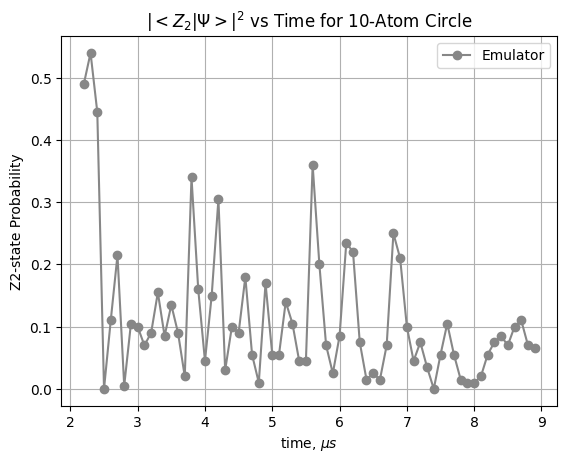

In [10]:
plt.plot(run_times, z2_probabilities, 'o-', label="Emulator", color="#878787")
plt.xlabel('time, $\mu s$')
plt.ylabel(f"Z2-state Probability")
plt.title(f'$|<Z_2|\Psi>|^2$ vs Time for {atom_pos.n_atoms}-Atom Circle')
plt.legend()
plt.grid()